## Chapter 3: Classification

Classification using MNIST dataset. Code based on the book, chapter III "Classification".

Modified to experiment with code

In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml


In [3]:
# Set as_frame = False to get a numpy array instead of the default pandas dataframe
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [4]:
X, y = mnist.data, mnist.target

### 1. Data Analysis

In [5]:
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (70000, 784)
y.shape: (70000,)


In [6]:
# Data = images of 28x28 pixels = 784 features
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
import matplotlib.pyplot as plt

def plot_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap='binary')
    plt.axis('off')

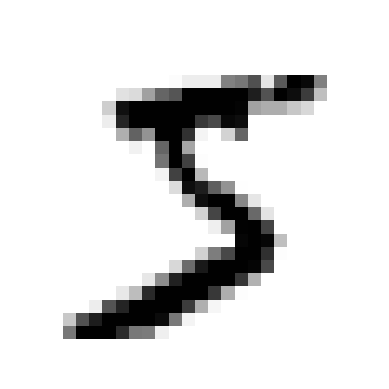

label: 5


In [9]:
first_digit = X[0]
plot_digit(first_digit)
plt.show()
print(f"label: {y[0]}")

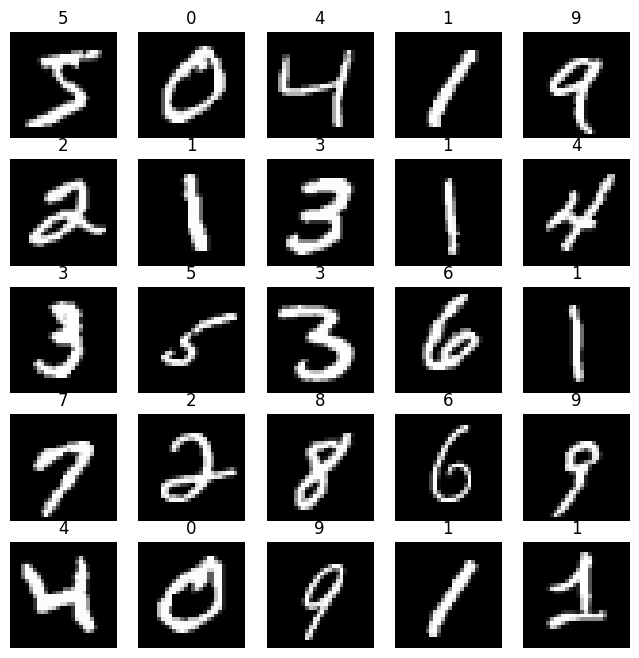

In [10]:
# Plot the first 25 images
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(y[i])
    ax.axis('off')

### 2. Split the data into training and test sets

In [11]:
# Training set is already shuffled
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3. Binary classifier
In first step, we will create a binary classifier that will be able to distinguish between 2 digits, for example 5 and not-5.

In [12]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [13]:
# First classifier: Stochastic Gradient Descent (SGD).
# This classifier has the advantage of being capable of handling very large datasets efficiently.

# SGD selects a random instance in the training set at every step and computes the gradients based only on that single instance.
# Compare this to Batch Gradient Descent, which uses the whole training set to compute the gradients at every step...
# ... and the Mini-batch Gradient Descent, which computes the gradients on batches of the dataset.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
# Test the classifier on the first digit
sgd_clf.predict([first_digit])

array([ True])

### 4. Performance Measures
#### 4.1 Cross-Validation

In [15]:
# Accuracy is the number of correct predictions divided by the total number of predictions.
# This is not a good metric for classifiers, especially with skewed datasets.
# In this example, only 10% of the images are 5s. Guessing that images are always not 5 will give 90% accuracy!
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

#### 4.2 Confusion Matrix

In [16]:
# Because of the issue described above, using a confusion matrix is better
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # Does not return scores, but predictions
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


First row: Negative class (non-5 images)  
Second row: Positive class (5 images)
___

First quadrant (53892): **True negatives (TN)**  
Second quadrant (687): **False positives (type I error)**  
  
Third quadrant (1891): **False negatives (type II error)**  
Fourth quadrant (3530): **True positives (TP)**
  

___
Precision = TP/(TP + FP)  
Recall = TP/(TP + FN)  
___
  

F1-score: Harmonic mean of Precision & Recall  
F1 = 2 x (Precision x Recall) / (Precision + Recall)

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"precision: {precision_score(y_train_5, y_train_pred):6.3f}")
# == 3530 / (3530 + 687) Only 83% of the 5s are correctly classified

print(f"recall: {recall_score(y_train_5, y_train_pred):9.3f}")
# == 3530 / (3530 + 1891) Only detects 65% of the 5s

print(f"f1 score: {f1_score(y_train_5, y_train_pred):7.3f}")

precision:  0.837
recall:     0.651
f1 score:   0.733


In [18]:
# Trying out different thresholds
import numpy as np
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function') # decision scores instead of predictions
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) # Compute precision and recall for all possible thresholds

In [19]:
index_90_precision = np.argmax(precisions >= 0.90)
threshold_90_precision = thresholds[index_90_precision]
print(threshold_90_precision)

3370.0194991439594


In [20]:
# Filter values above the threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(f"precision: {precision_score(y_train_5, y_train_pred_90):6.3f}")
print(f"recall: {recall_score(y_train_5, y_train_pred_90):9.3f}")
print(f"f1 score: {f1_score(y_train_5, y_train_pred_90):7.3f}")

precision:  0.900
recall:     0.480
f1 score:   0.626


In [21]:
# Scaling improves accuracy
from sklearn.preprocessing import StandardScaler
X_train_scaled = StandardScaler().fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train_5, cv=3, scoring='accuracy')

array([0.9713 , 0.9669 , 0.96785])

In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

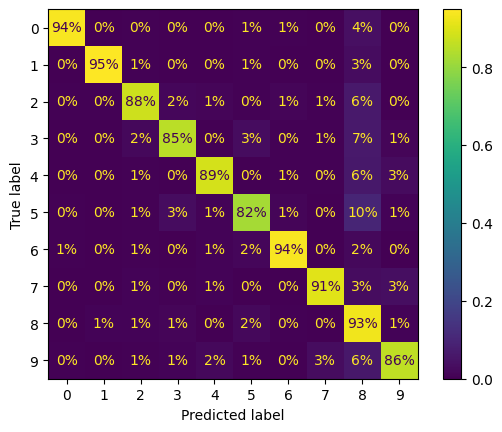

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize='true', values_format='.0%')
plt.show()

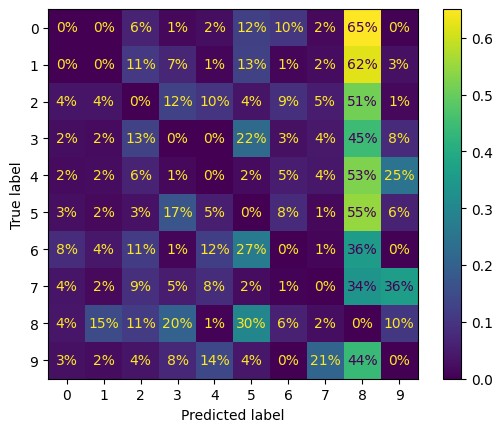

In [33]:
# Highlight errors
sample_weight = (y_train_pred != y_train) # Set correct predictions to 0, wrong predictions to 1
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize='true', values_format='.0%',
                                        sample_weight=sample_weight)
plt.show()